In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt 
import shapely
from shapely.geometry import LineString, Point, Polygon

# http://mathster.com/graphpaper/graphpaperjs/

In [3]:
def nb_show(img) :
    plt.imshow(img, cmap="gray"),plt.title('grid')
    plt.xticks([]),plt.yticks([])
    plt.show()

## Opening images

In [4]:
#@title Preprocessing functions {display-mode: "form"}
def get_bounding_box(img) :
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(img_gray,(5,5),0)
  ret,th3 = cv2.threshold(blur,150,255,cv2.THRESH_BINARY)
  edges = cv2.Canny(th3,100,200)
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  edges_copy = edges.copy()
  c = max(contours, key = cv2.contourArea)
  return cv2.boundingRect(c)

def resize_crop(img_in, box):
  x,y,w,h = box
  frame = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
  img_out = frame[y+25:y+h-10,x+10:x+w-10]
  return img_out


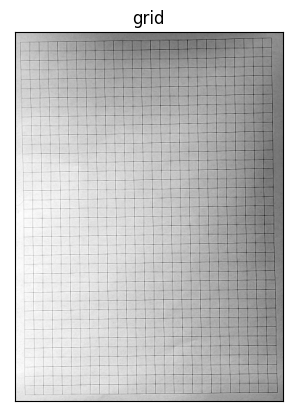

In [5]:
# Open files
frame  = cv2.imread("./content/frame-example.jpg")
background  = cv2.imread("./content/background-example.jpg")

# Resize by a k factor both pictures
k = 0.3
frame = cv2.resize(frame, (int(frame.shape[1] * k),int(frame.shape[0] * k)), interpolation = cv2.INTER_AREA)
background = cv2.resize(background, (int(background.shape[1] * k),int(background.shape[0] * k)), interpolation = cv2.INTER_AREA)

# Detect arena sheet and create a bounding rectangle around
bounding_box = get_bounding_box(background)

# Crop to the bounding rectangle found before
frame = resize_crop(frame,bounding_box)
background = resize_crop(background,bounding_box)
nb_show(background)


## Find lines and make a grid

In [6]:
#@title Hough transform processing functions{display-mode: "form"}
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)


    def denoise(self, noisy):
      kernel1 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]], np.uint8)
      kernel2 = np.array([[1, 1, 1],
                          [1, 0, 1],
                          [1, 1, 1]], np.uint8)
      hitormiss1 = cv2.morphologyEx(noisy, cv2.MORPH_ERODE, kernel1)
      hitormiss2 = cv2.morphologyEx(cv2.bitwise_not(noisy), cv2.MORPH_ERODE, kernel2)
      hitormiss = cv2.bitwise_and(hitormiss1, hitormiss2)
      hitormiss_comp = cv2.bitwise_not(hitormiss) 
      clean = cv2.bitwise_and(noisy, noisy, mask=hitormiss_comp)
      return clean

    def preprocessing(self, img_in):
      blur = cv2.GaussianBlur(img_in,(3,3),0)
      threshold = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,3,2)
      threshold = cv2.bitwise_not(threshold)
      threshold = self.denoise(threshold)
      kernel = np.ones((3,3))
      img_out = cv2.dilate(threshold, kernel, iterations=1)
      return img_out

In [7]:
#@title Grid manipulation functions {display-mode: "form"}

def linesSort(lines):
  lines_v = []
  lines_h = []
  delta_x = 20
  delta_y = 10

  for line in lines:
      x1, y1, x2, y2 = line[0]

      if x2 > x1 - delta_x and x2 < x1 + delta_x :
        lines_h.append(line)

      if y2 > y1 - delta_y and y2 < y1 + delta_y :
        lines_v.append(line)
  
  return lines_h,lines_v

def get_equation(p1, p2):
  A = (p1[1] - p2[1])
  B = (p2[0] - p1[0])
  C = (p1[0]*p2[1] - p2[0]*p1[1])
  return A, B, -C

def intersection(L1, L2):
  D  = L1[0] * L2[1] - L1[1] * L2[0]
  Dx = L1[2] * L2[1] - L1[1] * L2[2]
  Dy = L1[0] * L2[2] - L1[2] * L2[0]
  if D != 0:
    x = Dx / D
    y = Dy / D
    return int(x),int(y)
  else:
    return False

def closest_node(node, nodes):
  nodes = np.asarray(nodes)
  deltas = nodes - node
  dist_2 = np.einsum('ij,ij->i', deltas, deltas)
  return np.argmin(dist_2)

def lines_to_grid (lines):
  lines_h,lines_v = linesSort(lines)
  grid_list = []
  for lineh in lines_h :
    for linev in lines_v :
      L1 = get_equation([lineh[0][0],lineh[0][1]] ,[lineh[0][2],lineh[0][3]])
      L2 = get_equation([linev[0][0],linev[0][1]] ,[linev[0][2],linev[0][3]])
      R = intersection(L1, L2)
      # print(R)
      grid_list.append(R)
  nodes = np.array(sorted(grid_list , key=lambda k: [k[0], k[1]]))
  reshaped = np.reshape(nodes,(39,28,2)).astype(int)
  return reshaped

In [8]:
# Create HoughBundler instance to process lines given by cv2.HoughLinesP()
bundler = HoughBundler(min_distance=5,min_angle=5)
background_processed = bundler.preprocessing(background)
lines = cv2.HoughLinesP(background_processed, 1, np.pi / 180, 200, None, 50, 50)
lines = bundler.process_lines(lines)

# Convert processed lines to a point matrix
points_matrix = lines_to_grid(lines)

## Find centroid of object

In [9]:
#@title getObjectCentroid() function {display-mode: "form"}
def getObjectCentroid(bg, fr):
  x_centroid = 0
  y_centroid = 0
  
  # Diff
  fr = cv2.GaussianBlur(fr,(3,3),0)
  bg = cv2.GaussianBlur(bg,(3,3),0)
  diff = cv2.absdiff(bg, fr)

  # Erode
  ret,thresh = cv2.threshold(diff,100,255,cv2.THRESH_BINARY)
  kernel = np.ones((4,4), np.uint8) # Creating kernel
  eroded = cv2.erode(thresh, kernel)

  cXlist=[]
  cYlist=[]
  contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
  for c in sorted_contours:
      # calculate moments for each contour
      M = cv2.moments(c)
      if M["m00"] != 0:
          cX = int(M["m10"] / M["m00"])
          cY = int(M["m01"] / M["m00"])
          cXlist.append(cX)
          cYlist.append(cY)
      else:
          pass # do nothing, centroid value is not usable

  # Centroid findings
  if len(cXlist) > 0:
      x_centroid = cXlist[0]
      y_centroid = cYlist[0]
  else:
      print("no centroid found") # 

  return x_centroid,y_centroid

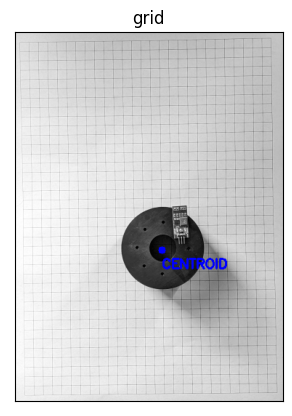

In [10]:
x_centroid,y_centroid = getObjectCentroid(background, frame)
diff_cpy = cv2.cvtColor(frame.copy(),cv2.COLOR_GRAY2RGB)
cv2.circle(diff_cpy, (x_centroid, y_centroid), 5, (0, 0, 255), -1)
cv2.putText(diff_cpy, "CENTROID", (x_centroid, y_centroid+25),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
nb_show(diff_cpy)

## Classes declarations

### Grid class

In [11]:
import shapely
from shapely.geometry import LineString, Point, Polygon

class Grid:
  def __init__(self, points_matrix):
    self.points_matrix = np.asarray(points_matrix)
    self.x_max = self.points_matrix.shape[0]
    self.y_max = self.points_matrix.shape[1]
    self.boundaries = self.calculate_boundaries()

  def find_closest_node(self, object):
    deltas = self.points_matrix.reshape((-1,2)) - object
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    min_dist = np.argmin(dist_2)
    ynode = int(min_dist/self.x_max)
    xnode = min_dist - ynode*self.x_max
    return xnode,ynode

  def calculate_boundaries(self):
    return LineString([Point((0,0)), Point(self.x_max, 0), Point(self.x_max, self.y_max), Point(0, self.y_max), Point(0, 0)])

### Sensor class

In [12]:
class Sensor:
  def __init__(self, pos, angle):
    self.pos = pos
    # self.measure = 0
    self.angle = angle 
    self.ray = 0

  # def setMeasure(self,meas):
  #   self.measure = meas

  def setRay(self,ray):
    self.ray = ray


### Robot class

In [13]:
def get_point_angle(start, angle):
  end = Point(int(start.x + 200 * math.cos(math.radians(angle))),
            int(start.y + 200 * math.sin(math.radians(angle))))
  return end

class Robot:
  def __init__(self, pos, theta, n_sensors):
    self.pos = pos
    self.theta = theta
    self.n_sensors = n_sensors
    self.sensors_array = []
    for n in range(self.n_sensors):
      sens = Sensor(self.pos,self.theta+n*360/self.n_sensors)
      self.sensors_array.append(sens)

  def calculate_distances(self, grid):
    hits = []
    distances = []
    for sensor in self.sensors_array:
      ray_end = get_point_angle(self.pos , sensor.angle)
      ray_infinite = LineString([self.pos,ray_end])
      hit = grid.boundaries.intersection(ray_infinite)
      ray = LineString([self.pos,hit])

      sensor.setRay(ray)
      distance = sensor.ray.length
      # sensor.setMeasure(distance)
      # distances.append(distance)
    # return distances

## Create model and calculate metrics

In [14]:
# Create a Grid instance
grid = Grid(points_matrix)

# Create a Robot instance
nsensors = 4
theta = 0
x_snap,y_snap = grid.find_closest_node((x_centroid, y_centroid))
spiderino = Robot(Point(x_snap,y_snap),theta,nsensors)

# Calculate distances of sensors to boundaries
spiderino.calculate_distances(grid)

## Nice plot

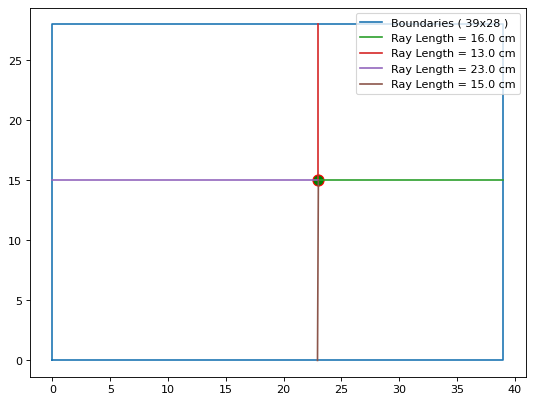

In [15]:
# importing the required module 
import matplotlib.pyplot as plt 

# x,y = grid.boundaries.exterior.xy
fig = plt.figure(figsize=(8, 6), dpi=80)

plt.plot(*grid.boundaries.xy, label="Boundaries ( "+ str(grid.x_max) +"x"+ str(grid.y_max) +" )")
plt.plot(*spiderino.pos.xy, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
for sensor in spiderino.sensors_array :
  plt.plot(*sensor.ray.xy, label="Ray Length = "+str(round((sensor.ray.length),2))+" cm")

leg = plt.legend()
plt.show()

# Viewer

snapped x,y :  23 15


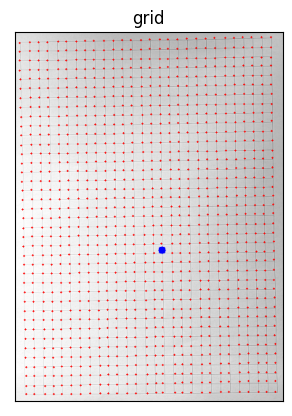

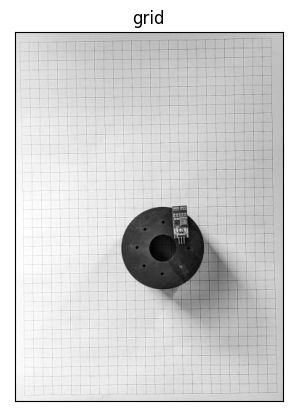

In [16]:

img_out = cv2.cvtColor(background.copy(),cv2.COLOR_GRAY2RGB)
for i in range(points_matrix.shape[0]):
  for j in range(points_matrix.shape[1]):
    cv2.circle(img_out, points_matrix[i][j][:] , radius=1, color=(255, 0, 0), thickness=-1)

x_snap,y_snap = grid.find_closest_node((x_centroid, y_centroid))
print("snapped x,y : ", x_snap,y_snap)
# print(grid.points_matrix[x_snap][y_snap])
cv2.circle(img_out, (x_centroid, y_centroid), 5, (0, 0, 255), -1)
# cv2.circle(img_out, (grid.points_matrix[x_snap][y_snap]), 10, (0, 255, 255), -1)
nb_show(img_out)
nb_show(frame)

# Taking Photos

In [106]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_BUFFERSIZE, 0)
WIDTH = 1920
HEIGHT = 1080
cam.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)

True

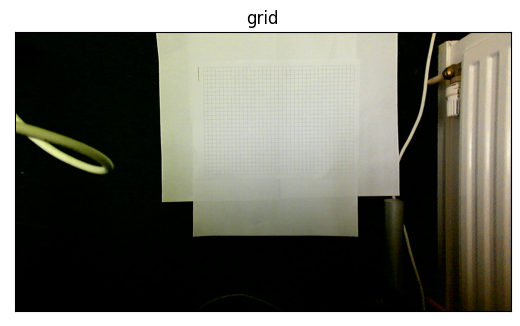

In [116]:
if cam.isOpened():
   ret, background = cam.read()
   if ret:
      nb_show(cv2.cvtColor(background, cv2.COLOR_RGB2BGR))
      cv2.imwrite('./content/background.jpg',background)
   else:
      print("frame not captured")
else:
   print("cannot open camera")


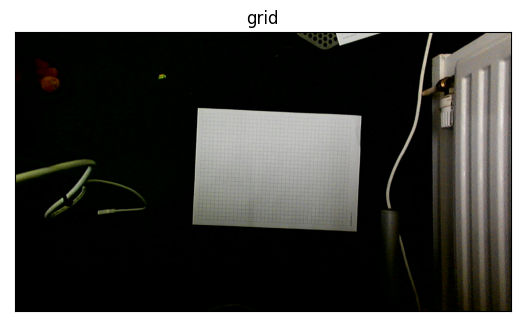

In [86]:
if cam.isOpened():
   ret, frame = cam.read()
   if ret:
      nb_show(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
      cv2.imwrite('./content/frame.jpg',frame)
   else:
      print("frame not captured")
else:
   print("cannot open camera")